## Implement of a curvature tensor

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import torch
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm
import pandas as pd
import skdim

In [71]:
def sub_vectors_between(set_vectors, a, b):
    # this function selects a set of vectors whose entries are between a and b
    
    filtered_vector = [[x for x in v if a < x < b] for v in set_vectors ]
    return filtered_vector        

def list_vector_indices_upto(list_indices, list_of_nums):
    result_list = [[list_indices[i][j] for j in range(list_of_nums[i] + 1)] for i in range(len(list_indices))]
    return result_list

def list_vector_of_index(set_vectors, list_indices):
    
    list_result_vectors = [np.array([set_vectors[i] for i in list_indices[j]]) for j in range(len(list_indices))]
    return list_result_vectors 


In [72]:
def find_basis_at_point(point_cloud, x, extrin_dim = 3, epsilon_PCA = 0.1, tau_ratio = 1.5):
    #point_cloud: the manifold 
    #x: np.array of shape 1 by p, the point where the curvature is evaluated at, e.g., [[1, 2, 3]]
    #epsilon: the radius of local PCA
    #dim: the dimension of the manifold
    #tau_ratio: the ratio is tau radius (where we evaluate the curvature)/ epsilon_sqrt
    epsilon_sqrt = np.sqrt(epsilon_PCA)
    tau = tau_ratio * epsilon_sqrt

    # Number of neighbors to find, we take 5% of the total population
    k = int(0.05 * point_cloud.shape[0])
    
    # Create a NearestNeighbors model
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(point_cloud)

    # Find k nearest neighbors
    dist_i, indx_i = nbrs.kneighbors(x)
    x_idx = indx_i[0][0]
    # Find epsilon neighborhood
    dist_epsilon = sub_vectors_between(dist_i, 0, epsilon_sqrt)
    len_dist_epsilon = [len(v) for v in dist_epsilon]
    epsilon_neighborhood = list_vector_of_index(point_cloud, list_vector_indices_upto(indx_i, len_dist_epsilon))[0]
    # Find tau neighborhood
    dist_tau = sub_vectors_between(dist_i, 0, tau)
    len_dist_tau = [len(v) for v in dist_tau]
    tau_neighborhood = list_vector_of_index(point_cloud, list_vector_indices_upto(indx_i, len_dist_tau))[0]
    num = len(tau_neighborhood)
    
    distances, indices = nbrs.kneighbors(tau_neighborhood)
    
    distances_epsilon = sub_vectors_between(distances, 0, epsilon_sqrt) # this is the list of distances in the epsilon
    list_len_dist_epsilon = [len(v) for v in distances_epsilon] #this gives the list of lengths in the distance_epsilon 
    
    tau_epsilon_neighborhood = list_vector_of_index(point_cloud, list_vector_indices_upto(indices, list_len_dist_epsilon))
    list_X_i = [tau_epsilon_neighborhood[i][1:] - tau_neighborhood[i] for i in range(num)]
    
    
    #list_D_i = [np.diag(np.sqrt(np.exp(- np.array(distances_epsilon[i]) ** 2 / epsilon_PCA))) for i in range(num)]
    list_D_i = [np.diag(np.sqrt(np.exp( - 8 * np.array(distances_epsilon[i]) ** 2 / epsilon_PCA))) for 
                i in range(num)]
    list_B_i = [list_X_i[j].T @ list_D_i[j] for j in range(num)]
    
    lpca = skdim.id.lPCA().fit_pw(point_cloud, n_neighbors = 10, n_jobs = 1)
    dim = lpca.dimension_pw_[x_idx]
    
    O = []
    for q in range(num):
        U, S, VT = np.linalg.svd(list_B_i[q].T)
        O_i = VT[:extrin_dim, :]
            
        O.append(O_i)
        
    return x_idx, dim, tau_neighborhood, O



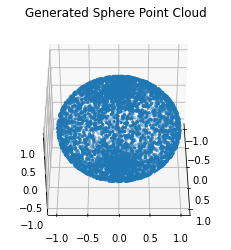

In [73]:
def generate_sphere_point_cloud(num_points, radius=1):
    theta = np.random.uniform(0, 2 * np.pi, num_points)
    phi = np.pi * np.random.uniform(0, np.pi, num_points)

    x = radius * np.sin(phi) * np.cos(theta)
    y = radius * np.sin(phi) * np.sin(theta)
    z = radius * np.cos(phi)

    return np.column_stack((x, y, z))

# Generate a sphere point cloud with 1000 points and radius 1
cloud = generate_sphere_point_cloud(5000, radius=1)

# Visualize the point cloud
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(cloud[:, 0], cloud[:, 1], cloud[:, 2], s=5)
ax.set_title("Generated Sphere Point Cloud")
ax.view_init(40, 0)
plt.show()

In [92]:
idx =1001

In [93]:
query_point = cloud[idx].reshape(1, -1)

x_idx, dim, tau_neighbor, O = find_basis_at_point(cloud, query_point, 
                                                  epsilon_PCA = 0.8, tau_ratio = 1)

In [94]:
U, S, VT = np.linalg.svd(O[4] @ O[6], full_matrices = False)
U @ VT

array([[-0.61674219, -0.11172917,  0.77919552],
       [ 0.70317578, -0.52310679,  0.4815632 ],
       [ 0.35379782,  0.84491176,  0.40118727]])

In [102]:
U, S, VT = np.linalg.svd(O[2].T @ O[3], full_matrices = False)
U @ VT @ O[0][0]

array([-0.14217669,  0.96183614,  0.23378842])

In [95]:
O[0][2]

array([0.86854471, 0.01496179, 0.49538493])

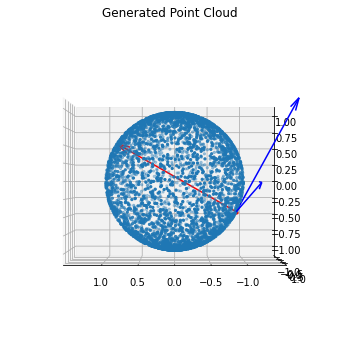

In [100]:
def plot_vector(ax, a, v, color='red', label=None):
    ax.quiver(a[0], a[1], a[2], v[0], v[1], v[2], color=color, label=label, arrow_length_ratio=0.1)

# Visualize the point cloud
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(cloud[:, 0], cloud[:, 1], cloud[:, 2], s=5)
ax.scatter(cloud[idx, 0], cloud[idx, 1], cloud[idx, 2], s=10, c = 'r')
plot_vector(ax, cloud[idx], 2* O[0][0], color='blue')
plot_vector(ax, cloud[idx], 2* O[0][1], color='blue')
plot_vector(ax, cloud[idx], 2* O[0][2])
ax.set_title("Generated Point Cloud")
ax.view_init(0, 90)
plt.axis('equal')
plt.show()


In [78]:
## the following is the old code

"""
def compute_curvature_at_point(point_cloud, query_point, extrin_dim = 3, epsilon_PCA = 0.1, tau_ratio = 1.5):
    
    x_idx, dim, tau_neighbor, O = find_basis_at_point(point_cloud, query_point, 
                                                      epsilon_PCA = epsilon_PCA, tau_ratio = tau_ratio)
    
    transport_maps = np.zeros((len(tau_neighbor), len(tau_neighbor), extrin_dim, extrin_dim))
    for i in range(len(tau_neighbor)):
        for j in range(len(tau_neighbor)):
            U, S, VT = np.linalg.svd(O[i].T @ O[j], full_matrices = False)
            O_ij = U @ VT
            transport_maps[i,j] = O_ij
            
    tensor_av = []

    O_init = O[0]  # this is the basis at point o, it is 2 x 3
    v_init = O_init[0] #choose the initial vector
    if dim == 1:
        for i in np.arange(1, len(tau_neighbor)):
            O_fin =  transport_maps[0, i] @ O_init[0]
            v_fin = O_fin
            cosin = (v_init @ v_fin.T) / (np.linalg.norm(v_init) * np.linalg.norm(v_fin))
            if cosin>1: cosin = 1
            if cosin<-1: cosin = -1
            angle = np.arccos(cosin)
            area = np.linalg.norm(tau_neighbor[i] - tau_neighbor[0])
            tensor = angle / area
            tensor_av.append(tensor)
    else: 
        for i in np.arange(1, len(tau_neighbor)):
            for j in np.arange(i + 1, len(tau_neighbor)):
                O_fin = transport_maps[0, i] @ transport_maps[i, j] @ transport_maps[j, 0] @ O_init.T
                v_fin = O_fin.T[0]
            
                cosin = (v_init @ v_fin.T) / (np.linalg.norm(v_init) * np.linalg.norm(v_fin))
                if cosin>1: cosin = 1
                if cosin<-1: cosin = -1
                angle = np.arccos(cosin)
                area = np.linalg.norm(np.cross(tau_neighbor[i] - tau_neighbor[0], tau_neighbor[j] - tau_neighbor[0])) / 2
            
                #tensor = angle / area
                tensor = (2 * np.pi - angle) / area 
            
                tensor_av.append(tensor)                                 
    
    tensor_av = sum(tensor_av)/len(tensor_av)
         
    return transport_maps, tensor_av
""" 

'\ndef compute_curvature_at_point(point_cloud, query_point, extrin_dim = 3, epsilon_PCA = 0.1, tau_ratio = 1.5):\n    \n    x_idx, dim, tau_neighbor, O = find_basis_at_point(point_cloud, query_point, \n                                                      epsilon_PCA = epsilon_PCA, tau_ratio = tau_ratio)\n    \n    transport_maps = np.zeros((len(tau_neighbor), len(tau_neighbor), extrin_dim, extrin_dim))\n    for i in range(len(tau_neighbor)):\n        for j in range(len(tau_neighbor)):\n            U, S, VT = np.linalg.svd(O[i].T @ O[j], full_matrices = False)\n            O_ij = U @ VT\n            transport_maps[i,j] = O_ij\n            \n    tensor_av = []\n\n    O_init = O[0]  # this is the basis at point o, it is 2 x 3\n    v_init = O_init[0] #choose the initial vector\n    if dim == 1:\n        for i in np.arange(1, len(tau_neighbor)):\n            O_fin =  transport_maps[0, i] @ O_init[0]\n            v_fin = O_fin\n            cosin = (v_init @ v_fin.T) / (np.linalg.norm(v_init

In [36]:
def compute_sectional_curvature(point_cloud, query_point, global_center, extrin_dim = 3, epsilon_PCA = 0.1, tau_ratio = 0.5):
    
    x_idx, dim, tau_neighbor, O = find_basis_at_point(point_cloud, query_point, global_center, extrin_dim = extrin_dim, 
                                                      epsilon_PCA = epsilon_PCA, tau_ratio = tau_ratio)
    
    transport_maps = np.zeros((len(tau_neighbor), len(tau_neighbor), dim, dim))
    for i in range(len(tau_neighbor)):
        for j in range(len(tau_neighbor)):
            U, S, VT = np.linalg.svd(O[i] @ O[j].T, full_matrices = False)
            O_ij = U @ VT
            transport_maps[i,j] = O_ij
            
    tensor_av = []
    v_init_1 = O[0][0]
    v_init_2 = O[0][1]
    normal = O[0][2] 
    for i in np.arange(1, len(tau_neighbor)):
        v_fin_1 = transport_maps[0, i] @ v_init_1
        kappa_1 =  ((v_fin_1 - v_init_1)/ np.linalg.norm(v_fin_1 - v_init_1)) @ normal
        
        v_fin_2 = transport_maps[0, i] @ v_init_2
        kappa_2 =  ((v_fin_2 - v_init_2)/ np.linalg.norm(v_fin_2 - v_init_2)) @ normal
        kappa = (kappa_1 + kappa_2)/2
        tensor_av.append(kappa)
        
    
    tensor_av = sum(tensor_av)/len(tensor_av)
         
    return transport_maps, tensor_av
 

In [47]:
def compute_sectional_curvature_1(point_cloud, query_point, global_center, extrin_dim = 3, epsilon_PCA = 0.1, tau_ratio = 0.5):
    
    x_idx, dim, tau_neighbor, O = find_basis_at_point(point_cloud, query_point, global_center, extrin_dim = extrin_dim, 
                                                      epsilon_PCA = epsilon_PCA, tau_ratio = tau_ratio)
   
            
    tensor_av = []
    e1_p = O[0][0]
    e2_p = O[0][1]

    normal = O[0][2] 
    for i in np.arange(1, len(tau_neighbor)):
        e1_q = O[i][0]
        kappa_1 =  ((e1_q - e1_p)/ np.linalg.norm(e1_q - e1_p)) @ normal
        
        e2_q = O[i][1]
        kappa_2 =  ((e2_q - e2_p)/ np.linalg.norm(e2_q - e2_p)) @ normal
        kappa = (kappa_1 + kappa_2)/2
        tensor_av.append(kappa)
        
    
    tensor_av = sum(tensor_av)/len(tensor_av)
         
    return tensor_av
 

In [40]:
np.sqrt(0.2)

0.4472135954999579

## Use differential of tangent vectors

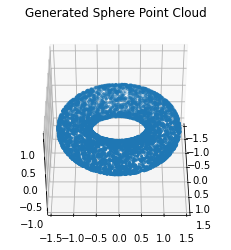

In [42]:
def generate_torus_point_cloud(num_points = 5000, R = 3, r = 1):
    # Generate random angles for theta and phi
    theta = np.random.uniform(0, 2*np.pi, num_points)
    phi = np.random.uniform(0, 2*np.pi, num_points)

    # Compute the torus points
    x = (R + r * np.cos(phi)) * np.cos(theta)
    y = (R + r * np.cos(phi)) * np.sin(theta)
    z = r * np.sin(phi)

    return np.column_stack((x, y, z))

# Create torus parameters
R = 1 # Major radius
r = 0.375  # Minor radius
num_samples = 5000



# Generate a sphere point cloud with 1000 points and radius 1
torus_cloud = generate_torus_point_cloud(num_points = num_samples, R = R, r = r)

# Visualize the point cloud
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(torus_cloud[:, 0], torus_cloud[:, 1], torus_cloud[:, 2], s=5)
ax.set_aspect('equal')
ax.set_title("Generated Sphere Point Cloud")
ax.view_init(40, 0)
plt.show()

In [45]:
num_eval = int(len(torus_cloud)/5)
center = np.array([[0, 0, 0]])
curvature = []
for i in tqdm(range(num_eval)):
    b = compute_sectional_curvature_1(torus_cloud, torus_cloud[i].reshape(1, -1), center, epsilon_PCA =0.1, tau_ratio = 1)
    curvature.append(b)

100%|██████████| 1000/1000 [12:48<00:00,  1.30it/s]


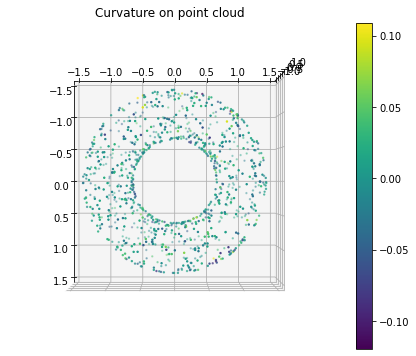

In [46]:
v = np.array(curvature).T
# Visualize the point cloud
cc = -v
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(torus_cloud[:num_eval, 0], torus_cloud[:num_eval, 1], torus_cloud[:num_eval, 2], s=2, c = cc)
ax.set_title("Curvature on point cloud")
ax.view_init(90, 0)
plt.colorbar(scatter)
ax.set_aspect('equal')
plt.show()

In [409]:
dd = np.clip(v, a_max=5, a_min=None)

In [364]:
np.argsort(v)[:20]

array([388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 187,
       172, 186, 171, 173,  12,   8,  13])

In [365]:
v[13]

9.755429511033384

In [259]:
def angle_between(u, v, n=None):
    
    if n is None:
        return np.arctan2(np.linalg.norm(np.cross(u,v)), np.dot(u,v))
    else:
        return np.arctan2(np.dot(n,np.cross(u,v)), np.dot(u,v))

In [265]:
u = O[0].T[0]
v = O[1].T[0]

In [277]:
angle_between(v, u, 1)

array([ 5.14172284e-03,  5.73146157e-17, -9.50858157e-17])

In [276]:
angle_between(u, v, 1)

array([-5.14172284e-03, -5.73146157e-17,  9.50858157e-17])